In [274]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Exploration

In [172]:
df = pd.read_csv('churn_telecom.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Yes
1,5575-GNVDE,Male,0,No,No,34,Yes,No,Fiber optic,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,Fiber optic,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [173]:
filtre = df['Churn'] == 'Yes'
len_churn = len(df[filtre])
len_total = len(df)
tx_churn = round(len_churn / len_total, 2) * 100

print(f"Le taux de churn est de {tx_churn}%")

Le taux de churn est de 32.0%


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [175]:
df.replace(
    {'TotalCharges':{
        ' ' : np.nan
    } }, inplace=True
)

In [176]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

## Data Viz

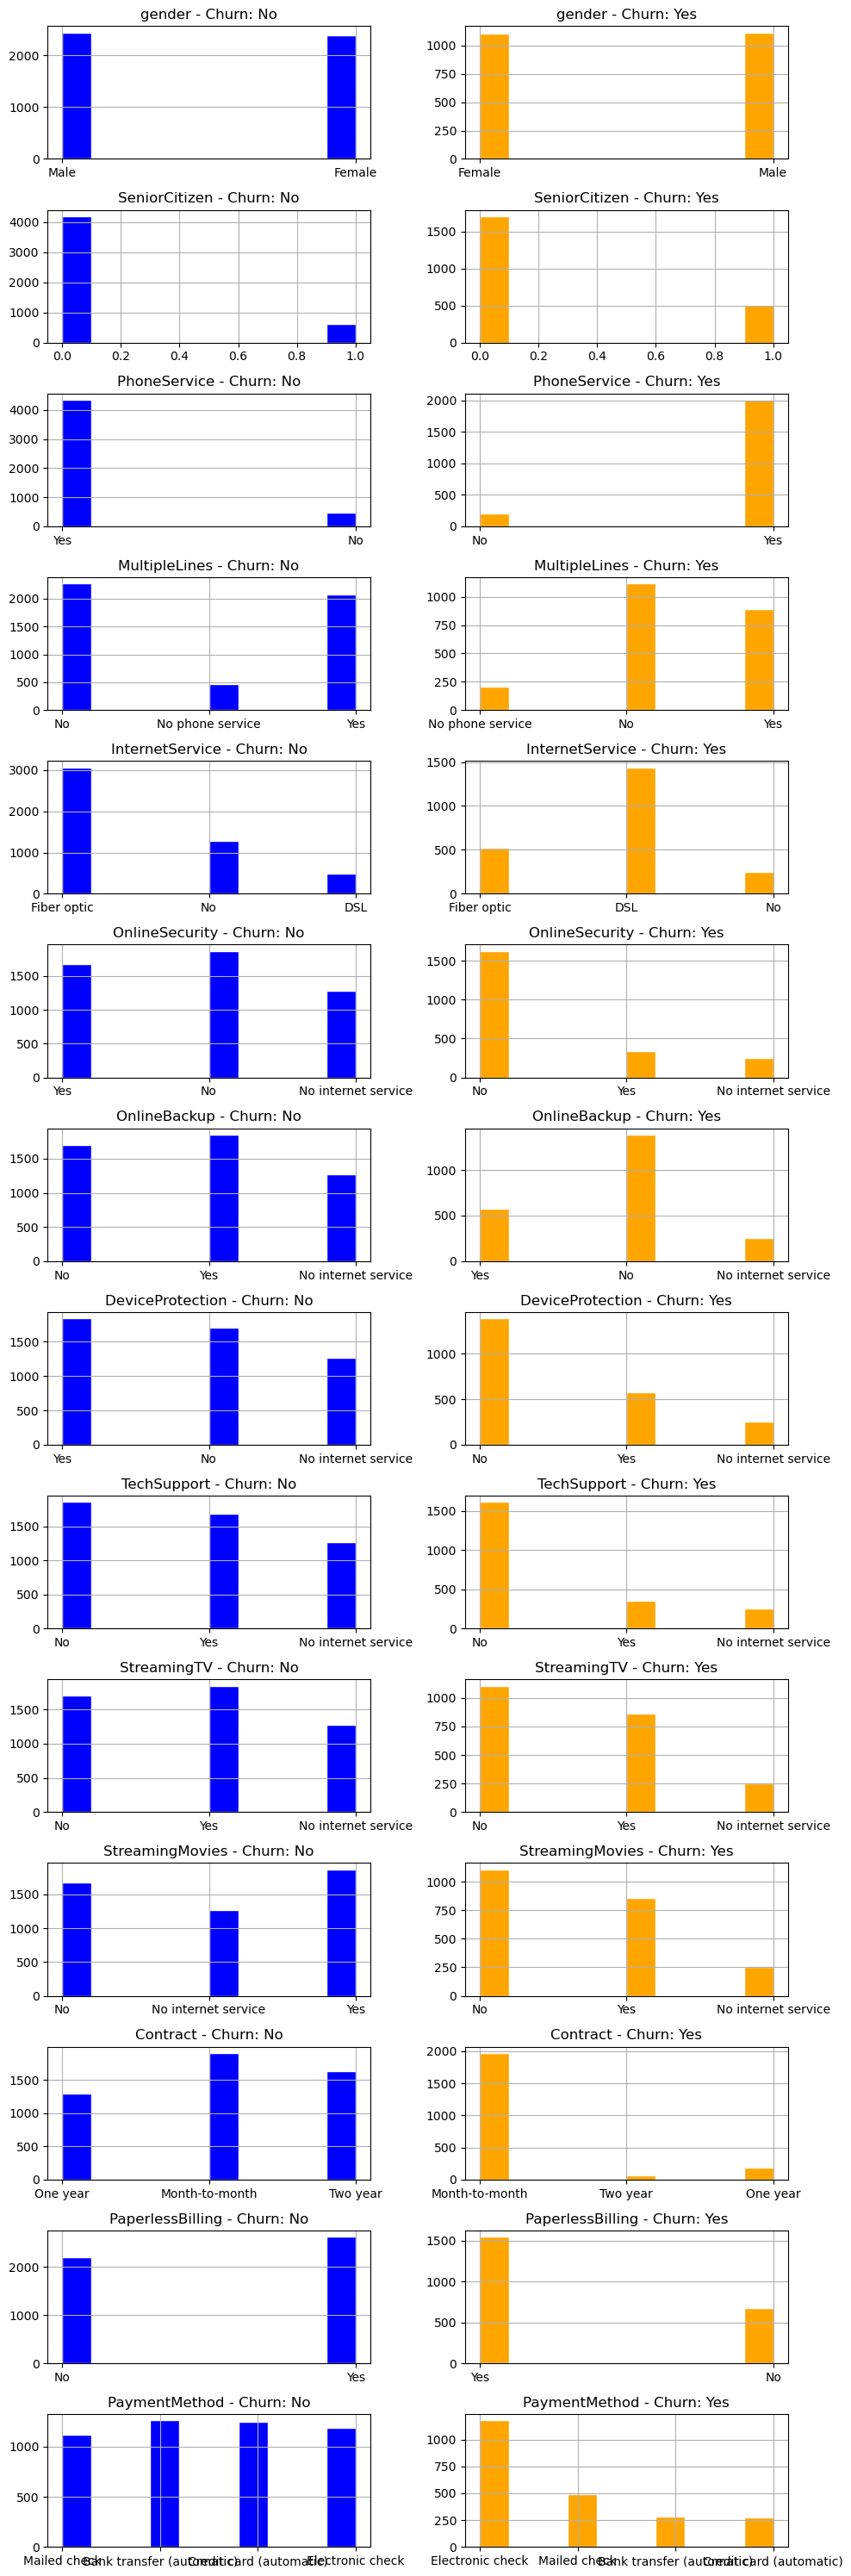

In [272]:
colums = [
    'gender',
    'SeniorCitizen',
    'PhoneService',
    'MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'Contract',
    'PaperlessBilling',
    'PaymentMethod'
]

fig, axes = plt.subplots(nrows=len(colums), ncols=2, figsize=(10, 30))

axes = axes.flatten()

groups = df['Churn'].unique()[::-1]

for i, col in enumerate(colums):
    for j, group in enumerate(groups):
        df[df['Churn'] == group][col].hist(
            ax=axes[2*i+j], 
            edgecolor='white',
            color= 'orange' if group == 'Yes' else 'blue'
        )
        axes[2*i+j].set_title(f'{col} - Churn: {group}') 
fig.tight_layout()
plt.show()

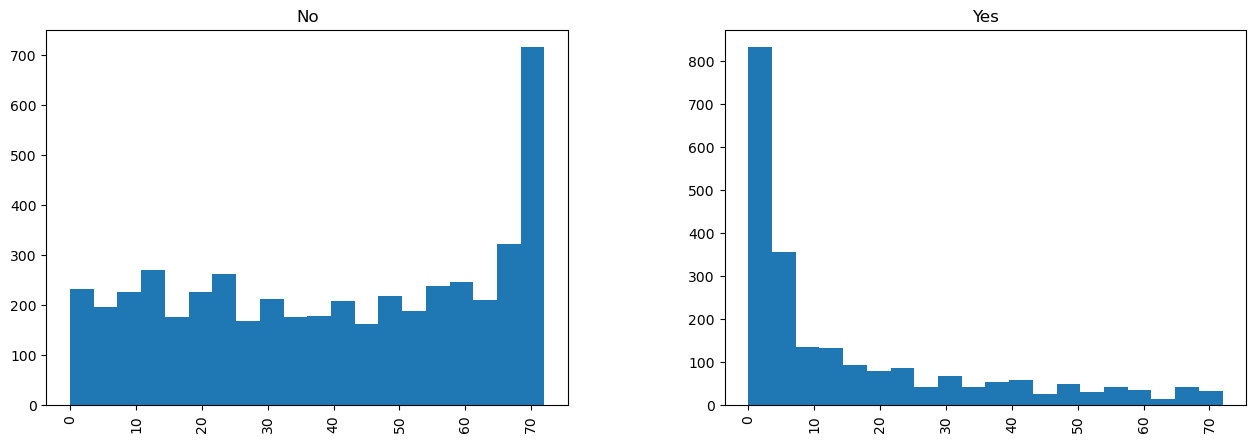

In [269]:
df.hist(
    'tenure',
    by='Churn',
    figsize=(15,5),
    bins=20
)

plt.show()

## First impressions:
The majority of customers who cancel their subscription seem to **have been subscribers for a short time** (less than 10 months). 

Overall, they subscribe to **fewer additional services** (little technical support, little device protection, etc.) and **lower-quality services** (more DSL than fiber optics).

Finally, these customers have signed up to a **month-to-month billing system**, rather than a one- or two-year commitment.

# Pipeline

In [177]:
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [275]:
num_col = df.select_dtypes('number').drop(columns='SeniorCitizen').columns
print(num_col)

bin_col = df.drop(columns=num_col).drop(columns=['customerID', 'Churn']).columns
print(bin_col)

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'churn_risk'], dtype='object')
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [180]:
num_tranformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessing = ColumnTransformer(
    transformers=[
        ('num', num_tranformer, num_col),
        ('cat', cat_transformer, bin_col)
    ]
)

pipeline = Pipeline([
    ('prepros', preprocessing)
])

In [181]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepros',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))]))])

In [182]:
X_train = pd.DataFrame(
    pipeline.fit_transform(X_train),
    columns=preprocessing.get_feature_names_out()
)


In [169]:
X_train

,num__tenure,num__MonthlyCharges,num__TotalCharges,cat__gender_Female,cat__gender_Male,cat__SeniorCitizen_0,cat__SeniorCitizen_1,cat__Partner_No,cat__Partner_Yes,cat__Dependents_No,...,cat__StreamingMovies_Yes,cat__Contract_Month-to-month,cat__Contract_One year,cat__Contract_Two year,cat__PaperlessBilling_No,cat__PaperlessBilling_Yes,cat__PaymentMethod_Bank transfer (automatic),cat__PaymentMethod_Credit card (automatic),cat__PaymentMethod_Electronic check,cat__PaymentMethod_Mailed check
0,-0.465683,-0.000474,-0.421357,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.885537,1.074754,1.255883,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,-1.284605,-1.376499,-1.002166,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-1.161766,0.177346,-0.907306,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.325551,-0.098524,-0.388632,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,-1.284605,1.001632,-0.970524,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5630,-0.383791,0.872006,-0.040372,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5631,-0.834198,-1.452945,-0.877190,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5632,-0.834198,1.149538,-0.481789,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [183]:
X_test = pd.DataFrame(
    pipeline.transform(X_test),
    columns=preprocessing.get_feature_names_out()
)


# Model : Logistic Regression

In [185]:
modelLogReg = LogisticRegression()
modelLogReg.fit(X_train, y_train)

LogisticRegression()

In [276]:
print(f"Score of the Regression model on the training data is   : {modelLogReg.score(X_train, y_train):.2f}")
print(f"Score of the Regression model on the test data is       : {modelLogReg.score(X_test, y_test):.2f}")

Score of the Regression model on the training data is   : 0.88
Score of the Regression model on the test data is       : 0.87


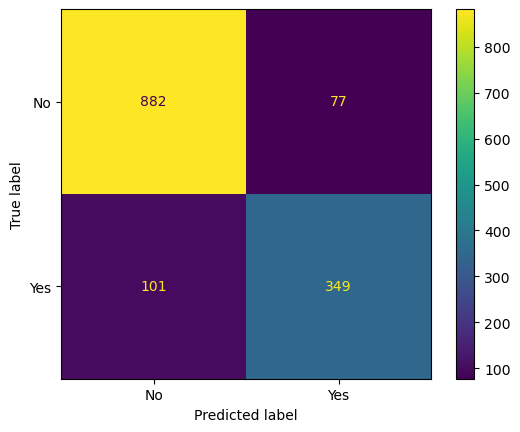

In [ ]:
y_pred = modelLogReg.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=pipeline.classes_)
disp.plot()
plt.show()

## Top 10 coefficients

In [210]:
coeff = pd.DataFrame(
    modelLogReg.coef_,
    columns=preprocessing.get_feature_names_out()
)
coeff.iloc[0].sort_values(ascending=False)[:10]

num__MonthlyCharges                         2.176090
num__TotalCharges                           2.143143
cat__InternetService_DSL                    1.856020
cat__PhoneService_No                        0.779811
cat__MultipleLines_No phone service         0.779811
cat__Contract_Month-to-month                0.603201
cat__OnlineBackup_No internet service       0.350480
cat__StreamingMovies_No internet service    0.350480
cat__StreamingTV_No internet service        0.350480
cat__OnlineSecurity_No internet service     0.350480
Name: 0, dtype: float64

## Predict proba

In [214]:
X_trans = pipeline.transform(X)
prediction = pd.DataFrame(
    modelLogReg.predict_proba(X_trans),
    columns=modelLogReg.classes_
)
prediction

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,No,Yes
0,0.602954,0.397046
1,0.995480,0.004520
2,0.152832,0.847168
3,0.998249,0.001751
4,0.010486,0.989514
...,...,...
7038,0.633914,0.366086
7039,0.949760,0.050240
7040,0.871041,0.128959
7041,0.473523,0.526477


In [217]:
churn_risk = pd.DataFrame()
churn_risk['churn_risk'] = prediction['Yes']

df = pd.concat([df, churn_risk], axis=1)
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_risk
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Yes,0.397046
1,5575-GNVDE,Male,0,No,No,34,Yes,No,Fiber optic,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0.004520
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0.847168
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,Fiber optic,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.001751
4,9237-HQITU,Female,0,No,No,2,Yes,No,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0.989514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0.366086
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,0.050240
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,Fiber optic,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0.128959
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,0.526477


# List of clients with high risk of churn

Clients that didn't churn yet but with high risk of churn according to their situation (risk 80% or higher)

In [283]:
no_churn = df['Churn'] == 'No'
high_churn_risk = df['churn_risk'] > 0.8

df[no_churn & high_churn_risk].sort_values('churn_risk', ascending=False)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_risk
211,4195-NZGTA,Female,0,No,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,No,Electronic check,25.25,25.25,No,0.978530
4400,5215-LNLDJ,Female,0,Yes,Yes,7,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,24.70,149.05,No,0.956295
3753,1816-FLZDK,Male,0,No,No,1,No,No phone service,DSL,No,...,Yes,No,No,Month-to-month,No,Mailed check,29.15,29.15,No,0.951295
3961,7421-ZLUPA,Female,0,No,No,8,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Mailed check,29.25,226.95,No,0.949610
5387,8676-OOQEJ,Male,0,No,No,4,No,No phone service,DSL,No,...,Yes,No,No,Month-to-month,No,Electronic check,30.50,118.40,No,0.949571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,2436-QBZFP,Female,0,Yes,Yes,22,No,No phone service,DSL,No,...,No,Yes,No,Month-to-month,No,Electronic check,39.20,849.90,No,0.817814
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No,0.817032
6905,4459-BBGHE,Male,0,No,Yes,30,No,No phone service,DSL,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,44.50,1307.80,No,0.814530
2588,5780-INQIK,Female,0,No,No,8,Yes,No,DSL,No,...,Yes,No,No,Month-to-month,No,Electronic check,49.40,408.25,No,0.812887
